# CS310 Natural Language Processing
# Lab 3: Word Vectors

Install `scikit-learn`, `matplotlib`, and `gensim` first

```bash
pip install -U scikit-learn matplotlib gensim
```

In [57]:
import itertools
from typing import List
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD

## T1. Latent Semantic Analysis (LSA) - A word-document based approach

We are working on the first ten chapters of 《论语》 (The Analects of Confucius) in this lab. The text is in Chinese (with punctuations).

First, load the corpus data from the folder `lunyu` into a list of documents. We read all lines from the ten TXT files and combine them into a list of strings, `documents`. Each line of text is considered as a *document*.

The file names are in the format of `text_ch1.txt`, `text_ch2.txt`, ..., `text_ch10.txt`.

In [58]:
documents = []
for i in range(1, 11):
    with open(f"lunyu/text_ch{i}.txt", "r") as f:
        for line in f:
            documents.append(line.strip())

# Test result
print(len(documents))
print(documents[:3])

267
['子曰： 学而时习之，不亦说乎？有朋自远方来，不亦乐乎？人不知而不愠，不亦君子乎？', '有子曰： 其为人也孝弟，而好犯上者，鲜矣；不好犯上而好作乱者，未之有也。君子务本，本立而道生。孝弟也者，其为仁之本与！', '子曰： 巧言令色，鲜矣仁！']


**Clean the data**

Replace spaces `' '` with empty string `''`

In [59]:
### START TODO ###
documents = [document.replace(' ', '') for document in documents]
### END TODO ###
documents[:3]


['子曰：学而时习之，不亦说乎？有朋自远方来，不亦乐乎？人不知而不愠，不亦君子乎？',
 '有子曰：其为人也孝弟，而好犯上者，鲜矣；不好犯上而好作乱者，未之有也。君子务本，本立而道生。孝弟也者，其为仁之本与！',
 '子曰：巧言令色，鲜矣仁！']

Concatenate all documents into a single string `words`, whose length is the number of tokens in the corpus.

In [60]:
### START TODO ###
words: str = ''.join(documents)
### END TODO ###

In [61]:
# Test result
print(len(words))

# You are expected to see the following output:
# 8664

8664


**Build vocabulary**

Use `collections.Counter` to build a vocabulary of characters (字) from the cleaned data. Yes, we do not use word segmentation here. 

In [62]:
from collections import Counter

### START TODO ###
vocab = Counter(words)
### END TODO ###

In [63]:
# Test result
print(vocab.most_common(10))

# You are expected to see the following output:
# [('，', 738), ('。', 405), ('子', 402), ('：', 339), ('曰', 318), ...

[('，', 738), ('。', 405), ('子', 402), ('：', 339), ('曰', 318), ('不', 272), ('也', 254), ('之', 251), ('而', 155), ('？', 126)]


**Build `word2index`**

Use the vocabulary to build a `word2index` dictionary, which maps each character to an integer index.

The order of indices should be the descending order of character frequency, i.e., the most frequent character has index 0, the second most frequent character has index 1, and so on.

For example: 
```python
>>> word2index['，']
>>> 0
>>> word2index['。']
>>> 1
```

In [64]:
### START TODO ###
word2index = {char: idx for idx, (char, _) in enumerate(vocab.most_common())}
### END TODO ###

In [65]:
# Test result
print(list(itertools.islice(word2index.items(), 10)))

# You are expected to see the following output:
# [('，', 0), ('。', 1), ('子', 2), ('：', 3), ('曰', 4), ('不', 5), ('也', 6), ('之', 7), ('而', 8), ('？', 9)]

[('，', 0), ('。', 1), ('子', 2), ('：', 3), ('曰', 4), ('不', 5), ('也', 6), ('之', 7), ('而', 8), ('？', 9)]


**Initialize word-document matrix**

Use `numpy.zeros()` to initialize a word-document matrix `A` with shape `(vocab-size, num-documents)`.

In [66]:
import numpy as np

### START TODO ###
vocab_size = len(vocab) 
num_documents = len(documents) 
A = np.zeros((vocab_size, num_documents))
### END TODO ###

# Test result
print(A.shape)
print(A)
# You should see a matrix of all zeros with the shape of (vocab_size, num_documents)

(986, 267)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Fill in the entries of word-document matrix**

`A[i, j]` is the frequency of word `i` in document `j`. For simplicity, you can go through each document and count the frequency of each word that has appeared in the document.

You may need the `word2index` dictionary to convert a word to its index, so that the correct row index `i` can be found. The column index `j` is the document index in the list `documents`.

In [67]:
# Assert A is all zeros; if not, run the previous cell to reset A
assert np.all(A == 0)
            
### START TODO ###
for i, d in enumerate(documents): 
    for character in d:  
        if character in word2index: 
            w = word2index[character]  
            A[w, i] += 1  
### END TODO ###

In [68]:
# Test result
print(A[:5, :5])

# You are expected to see the following output:
# [[3. 5. 1. 0. 3.]
#  [0. 2. 0. 0. 1.]
#  [2. 2. 1. 1. 1.]
#  [1. 1. 1. 2. 1.]
#  [1. 1. 1. 1. 1.]]

[[3. 5. 1. 0. 3.]
 [0. 2. 0. 0. 1.]
 [2. 2. 1. 1. 1.]
 [1. 1. 1. 2. 1.]
 [1. 1. 1. 1. 1.]]


**Compute probabilities from the matrix**

What is the total number of occurrences of the character "学" in the corpus?

*Hint*: Use `numpy.sun()` on the correct subset of the matrix `A`.

In [69]:
### START TODO ###
index_of_char = word2index.get("学") 
count = np.sum(A[index_of_char, :]) if index_of_char is not None else 0  
### END TODO ###


# Test result
print(count)
# You are expected to see the following output:
# 25.0

25.0


What is the expected count of the character "学" in the first document -- "子曰：学而时习之，不亦说乎？有朋自远方来，不亦乐乎？人不知而不愠，不亦君子乎？" (`documents[0]`)?

*Hint*: First, compute the global unigram probability of `学`, then multiply it by the number of words in the first document.

In [70]:
### START TODO ###
index_of_学 = word2index["学"]
total_occurrences_of_学 = np.sum(A[index_of_学, :])
total_number_of_characters = np.sum(A)
global_unigram_probability_of_学 = total_occurrences_of_学 / total_number_of_characters

prob = global_unigram_probability_of_学

num_chars_in_first_doc=len(documents[0])
expected_count = prob * num_chars_in_first_doc
### END TODO ###


# Test result
print(expected_count)
# You are expected to see the following output:
# 0.11253462603878117

0.11253462603878117


What is the *pointwise mutual information* (PMI) of the character "学", or "surprise" in `document[0]`? What about in document[1]?

Complete the implementation of the function `PMI(word, doc, A, word2index, n_words, documents)`

*Hint*: 
- Use the formula for PMI: $\log(\frac{\text{observed count}}{\text{expected count}})$
- Handle the case when the observed count is 0, where the PMI is undefined. In this case, return 0.
- The $[]_+$ operation means that we want to keep the PMI value positive. You can use `max()` to achieve this.

In [71]:
### START TODO ###
def PMI(word: str, doc: int, 
    A: np.ndarray, word2index: dict, 
    n_words: int, documents: List[str]) -> float:
    """ Compute the pointwise mutual information of a word in a document.
    Args:
        word: The word to compute PMI for.
        doc: The document index.
        A: The word-document count matrix.
        word2index: The word to index mapping.
        n_words: The number of words in the corpus.
        documents: The list of documents.
    """
    """ Compute the pointwise mutual information of a word in a document."""
    if word not in word2index:
        return 0  
    
    observed_count = A[word2index[word], doc]
    
    if observed_count == 0:
        return 0  
    
    word_total_count = np.sum(A[word2index[word], :])
    doc_length = len(documents[doc])
    expected_count = (word_total_count * doc_length) / n_words

    pmi = max(0, np.log(observed_count / expected_count))
    return pmi
### END TODO ###

# Test result
print(PMI('学', 0, A, word2index, len(words), documents))
print(PMI('学', 1, A, word2index, len(words), documents))
# You are expected to see the following output:
# 2.1844943176829794
# 0

2.1844943176829794
0


**Implement LSA using Truncated SVD**

Use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). (Check the documentation for more details)


Set the number of components to 2, and fit the model with the word-document matrix `A`.

Save the dimension reduced matrix to `M`.

In [72]:
### START TODO ###
n_components = 2  
svd = TruncatedSVD(n_components=n_components) 
M = svd.fit_transform(A) 
### END TODO ###

In [73]:
# Test result
print(M.shape)
print(M[word2index['学'],:])

# You are expected to see the following output:
# (986, 2)
# [1.41745292 0.4941003 ]

(986, 2)
[1.41745292 0.49414623]


Plot some words in the 2D space.

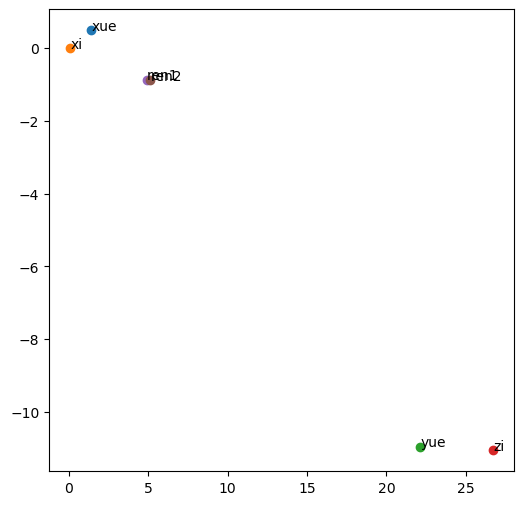

In [74]:
words = ['学', '习', '曰', '子', '人', '仁']
words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']

plt.figure(figsize=(6, 6))
for i, word in enumerate(words):
    plt.scatter(M[word2index[word], 0], M[word2index[word], 1])
    plt.text(M[word2index[word], 0], M[word2index[word], 1], words_pinyin[i])
plt.show()

## T2. Play with Pretrained Word Vectors

Checkout the `gensim` library and its `downloader` API here: https://radimrehurek.com/gensim/downloader.html

In [75]:
def load_embedding_model():
    """ Load Pretrained Vectors
        Return:
            wv_from_bin: All embeddings, each lengh 200 (or 300 if using Google News)
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200") # file size 252.1MB, vocab size 400k, dim 200
    # You can also try "word2vec-google-news-300", which is much larger 1600+MB
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin


# Run this to get the full corpora information
# import gensim.downloader as api
# api.info()

In [76]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


Play with word analogy task using the `most_similar` method of the `KeyedVectors` class.

In [77]:
import pprint

# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659888029098511),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767380714417),
 ('grandparents', 0.6446609497070312),
 ('wife', 0.6445354223251343)]


Follow the above example and try any other analogy tasks you like.

For instance, China: Beijing = Japan: ?

In [78]:
### START TODO ###
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'sister'], negative=['woman']))
### END TODO ###

[('brother', 0.7270498871803284),
 ('father', 0.6531276702880859),
 ('cousin', 0.6404421329498291),
 ('son', 0.6370454430580139),
 ('uncle', 0.6317039728164673),
 ('sons', 0.6011109352111816),
 ('friend', 0.5927498936653137),
 ('nephew', 0.5820999145507812),
 ('mother', 0.5816723704338074),
 ('daughter', 0.561065137386322)]
